In [1]:
from config_test import *

from sklearn import model_selection
from matplotlib.pyplot import *
from theano import shared, config
import numpy as np

from deepensemble.metrics import *
from deepensemble.utils import *


data_input, data_target, classes_labels, name_db, desc, col_names = \
    load_data('germannumer_scale', data_home='../../test_models/data', normalize=False)

# Generate testing and training sets
input_train, input_test, target_train, target_test = \
    model_selection.train_test_split(data_input, data_target, test_size=0.3)

In [2]:
n_features = data_input.shape[1]
n_classes = len(classes_labels)

n_output = n_classes
n_inputs = n_features

n_neurons_model = int(0.5 * (n_output + n_inputs))

n_ensemble_models = 3
fn_activation1 = ActivationFunctions.sigmoid
fn_activation2 = ActivationFunctions.sigmoid

y = get_index_label_classes(translate_target(data_target, classes_labels))
s = ITLFunctions.silverman(shared(np.array(y))).eval()

list_scores = [
    {'fun_score': mutual_information_parzen, 'name': 'Mutual Information'},
    {'fun_score': mutual_information_cs, 'name': 'QMI CS'},
    {'fun_score': mutual_information_ed, 'name': 'QMI ED'}
]

print('Silverman: %0.4g' % s)

batch_size = 32
max_epoch = 500
n_ensemble_models = 3

lr = 0.1

args_train_default = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True}

args_train_cip = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

Silverman: 0.4523


In [3]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble MSE', classification=True, classes_labels=classes_labels,
                              n_input=n_features, n_output=n_output,
                              n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                              fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                              cost=mse, name_cost="MSE",
                              params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

# Compile
ensemble.compile(fast=True)

# training
metrics = ensemble.fit(input_train, target_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Comienza la compilación Ensamble MSE  - elapsed: 1.35 [s]
Ensamble MSE - fold: 1, epoch:[####################] 500/500 elapsed: 5.76[s] - left: 0.00[s] | score: 0.8043 / 0.6875
FINISHED!


In [4]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL', classification=True, classes_labels=classes_labels,
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        lamb=0.8, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)

# Compile
ensembleNCL.compile(fast=True)
                      
# training
metrics = ensembleNCL.fit(input_train, target_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Comienza la compilación Ensamble NCL  - elapsed: 2.73 [s]
Ensamble NCL - fold: 1, epoch:[####################] 500/500 elapsed: 8.44[s] - left: 0.00[s] | score: 0.7961 / 0.7812
FINISHED!


In [5]:
# Create MLP
mlp = get_mlp_model("MLP (%d neuronas)" % (n_neurons_model * n_ensemble_models),
                           classification=True, classes_labels=classes_labels,
                           n_input=n_features, n_output=n_output,
                           n_neurons=n_neurons_model,
                           fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                           cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)

# Compile
mlp.compile(fast=True)
                      
# training
metrics = mlp.fit(input_train, target_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Comienza la compilación MLP (39 neuronas)  - elapsed: 0.29 [s]
MLP (39 neuronas) - fold: 1, epoch:[####################] 500/500 elapsed: 2.86[s] - left: 0.00[s] | score: 0.8026 / 0.8125
FINISHED!


In [6]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIPL', classification=True, classes_labels=classes_labels,
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.3, lamb=0.3, s=s,
                                    lsp=1.5, lsm=0.5,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -5*lr})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)

# Compile
ensembleCIP.compile(fast=False)
                      
# training
metrics = ensembleCIP.fit(input_train, target_train, **args_train_cip)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Comienza la compilación Ensamble CIPL  - elapsed: 10.10 [s]
Ensamble CIPL - fold: 1, epoch:[####################] 500/500 elapsed: 24.40[s] - left: 0.00[s] | score: 0.6694 / 0.53128
FINISHED!


<IPython.core.display.Javascript object>


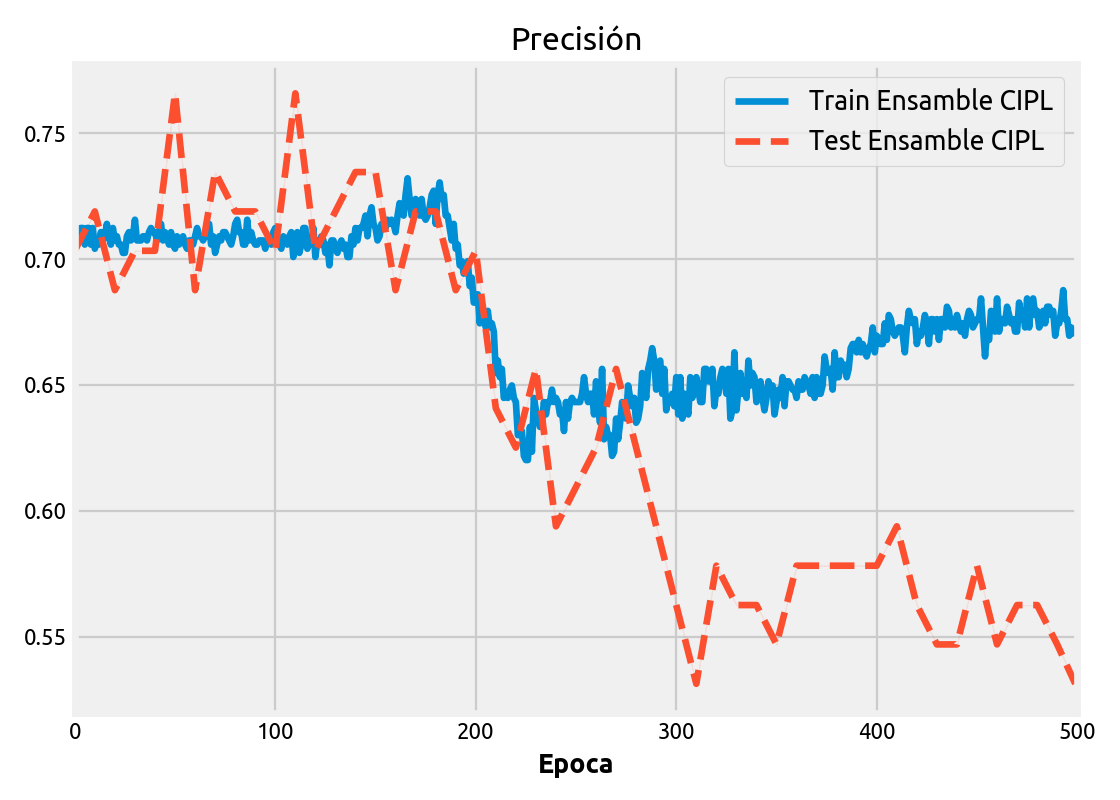

<IPython.core.display.Javascript object>


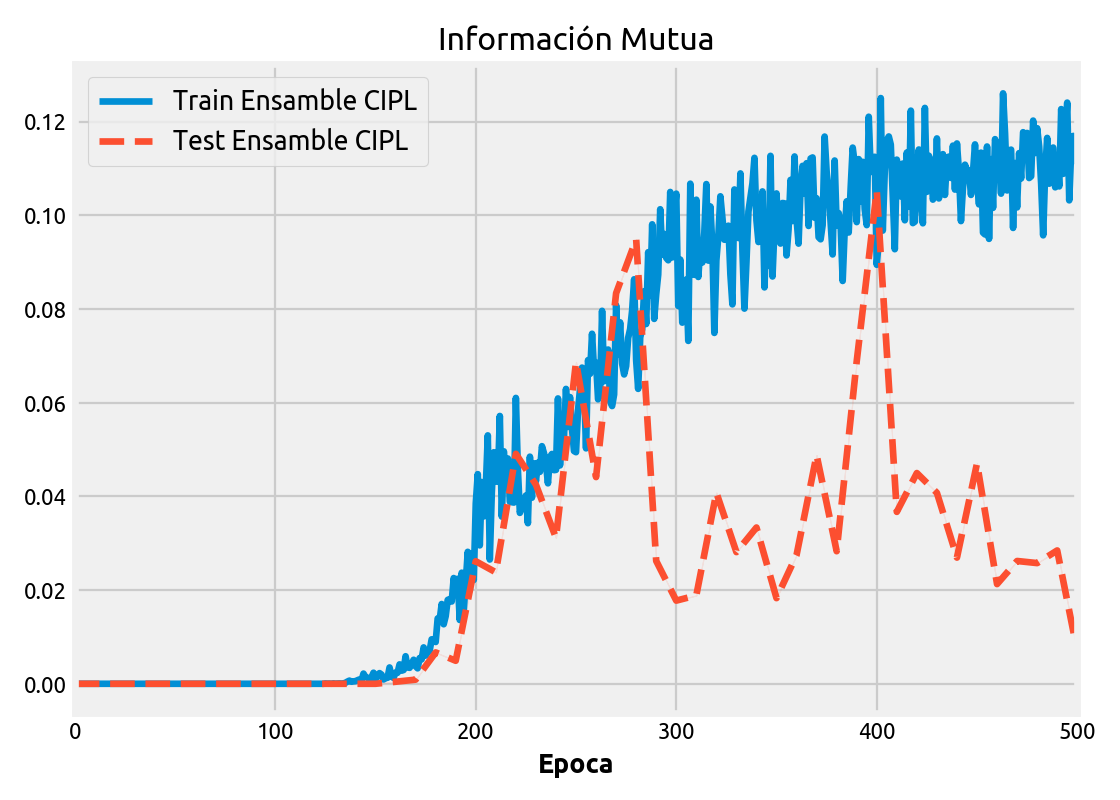

<IPython.core.display.Javascript object>


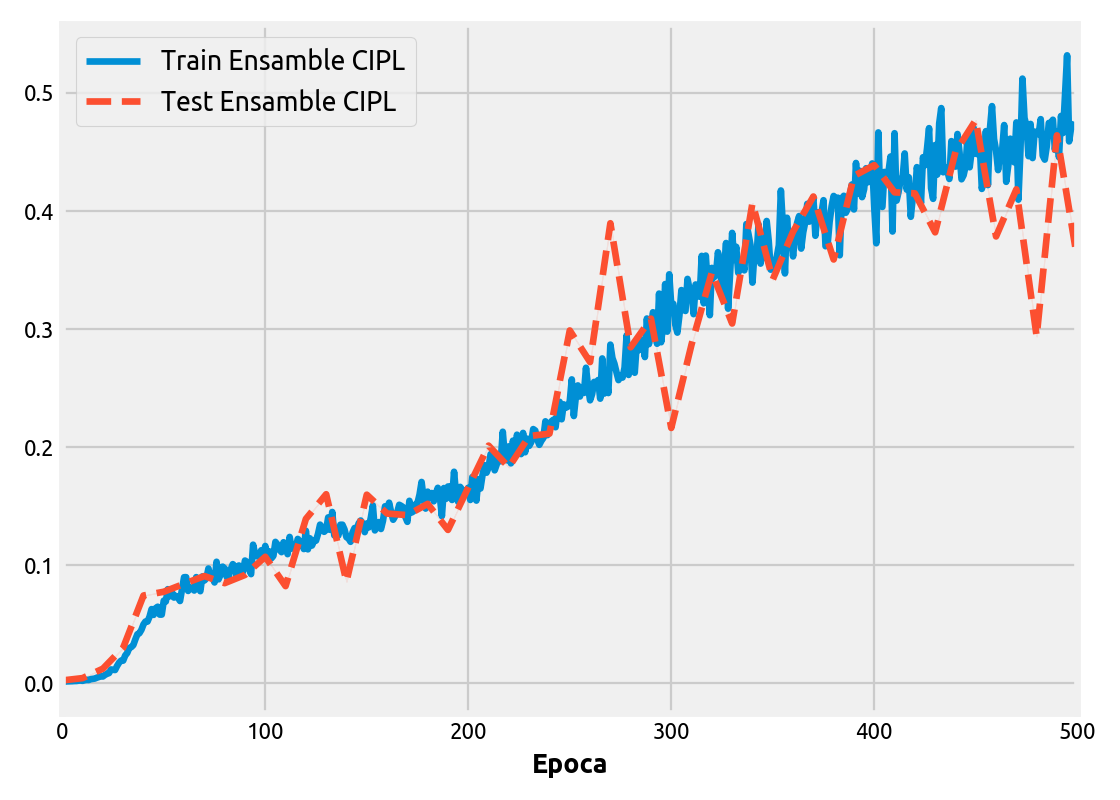

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt

metrics_ensembleCIP.plot_scores(max_epoch=max_epoch, title='')
metrics_ensembleCIP.plot_cost(max_epoch=max_epoch, title='')

plt.show()

<IPython.core.display.Javascript object>


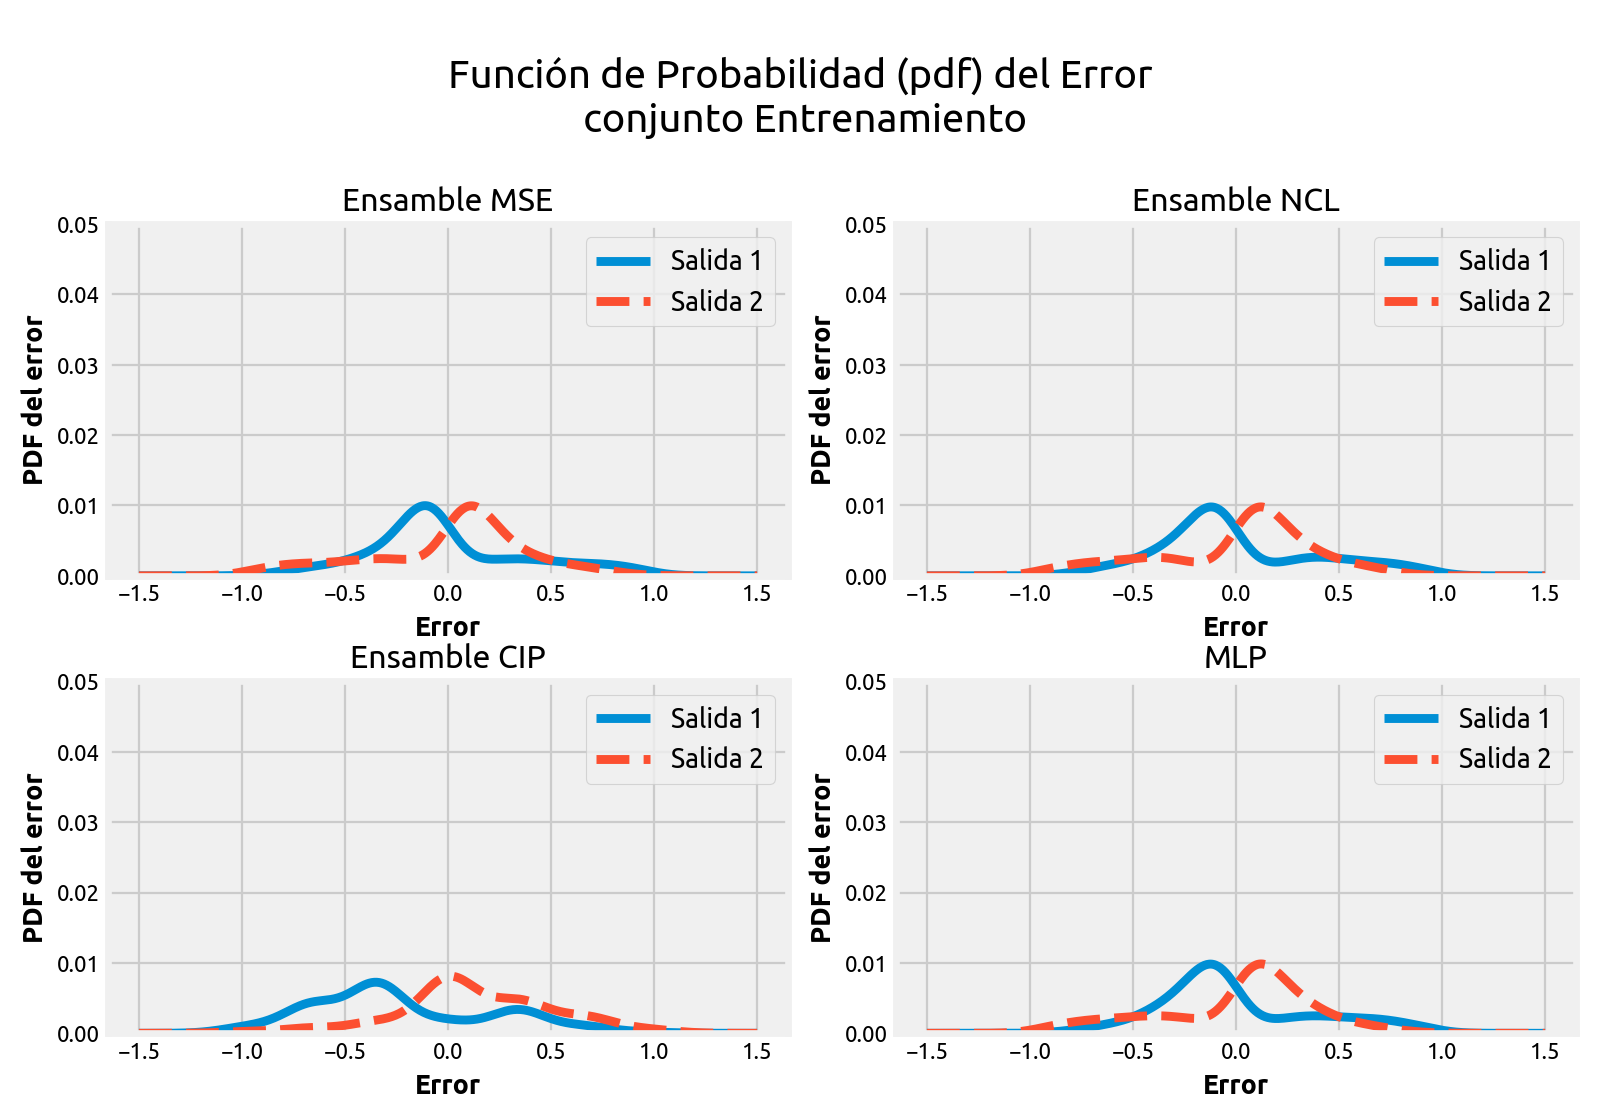

In [8]:
fig = plt.figure(figsize=(10, 7), dpi=80)

ax = fig.add_subplot(2, 2, 1)
plot_pdf_error(ensemble, input_train, target_train, 'Ensamble MSE', ax, fig)

ax = fig.add_subplot(2, 2, 2)
plot_pdf_error(ensembleNCL, input_train, target_train, 'Ensamble NCL', ax, fig)

ax = fig.add_subplot(2, 2, 3)
plot_pdf_error(ensembleCIP, input_train, target_train, 'Ensamble CIP', ax, fig)

ax = fig.add_subplot(2, 2, 4)
plot_pdf_error(mlp, input_train, target_train, 'MLP', ax, fig)

st = fig.suptitle("Función de Probabilidad (pdf) del Error\n conjunto Entrenamiento", fontsize=18)

st.set_y(0.95)
fig.subplots_adjust(top=0.8)


<IPython.core.display.Javascript object>


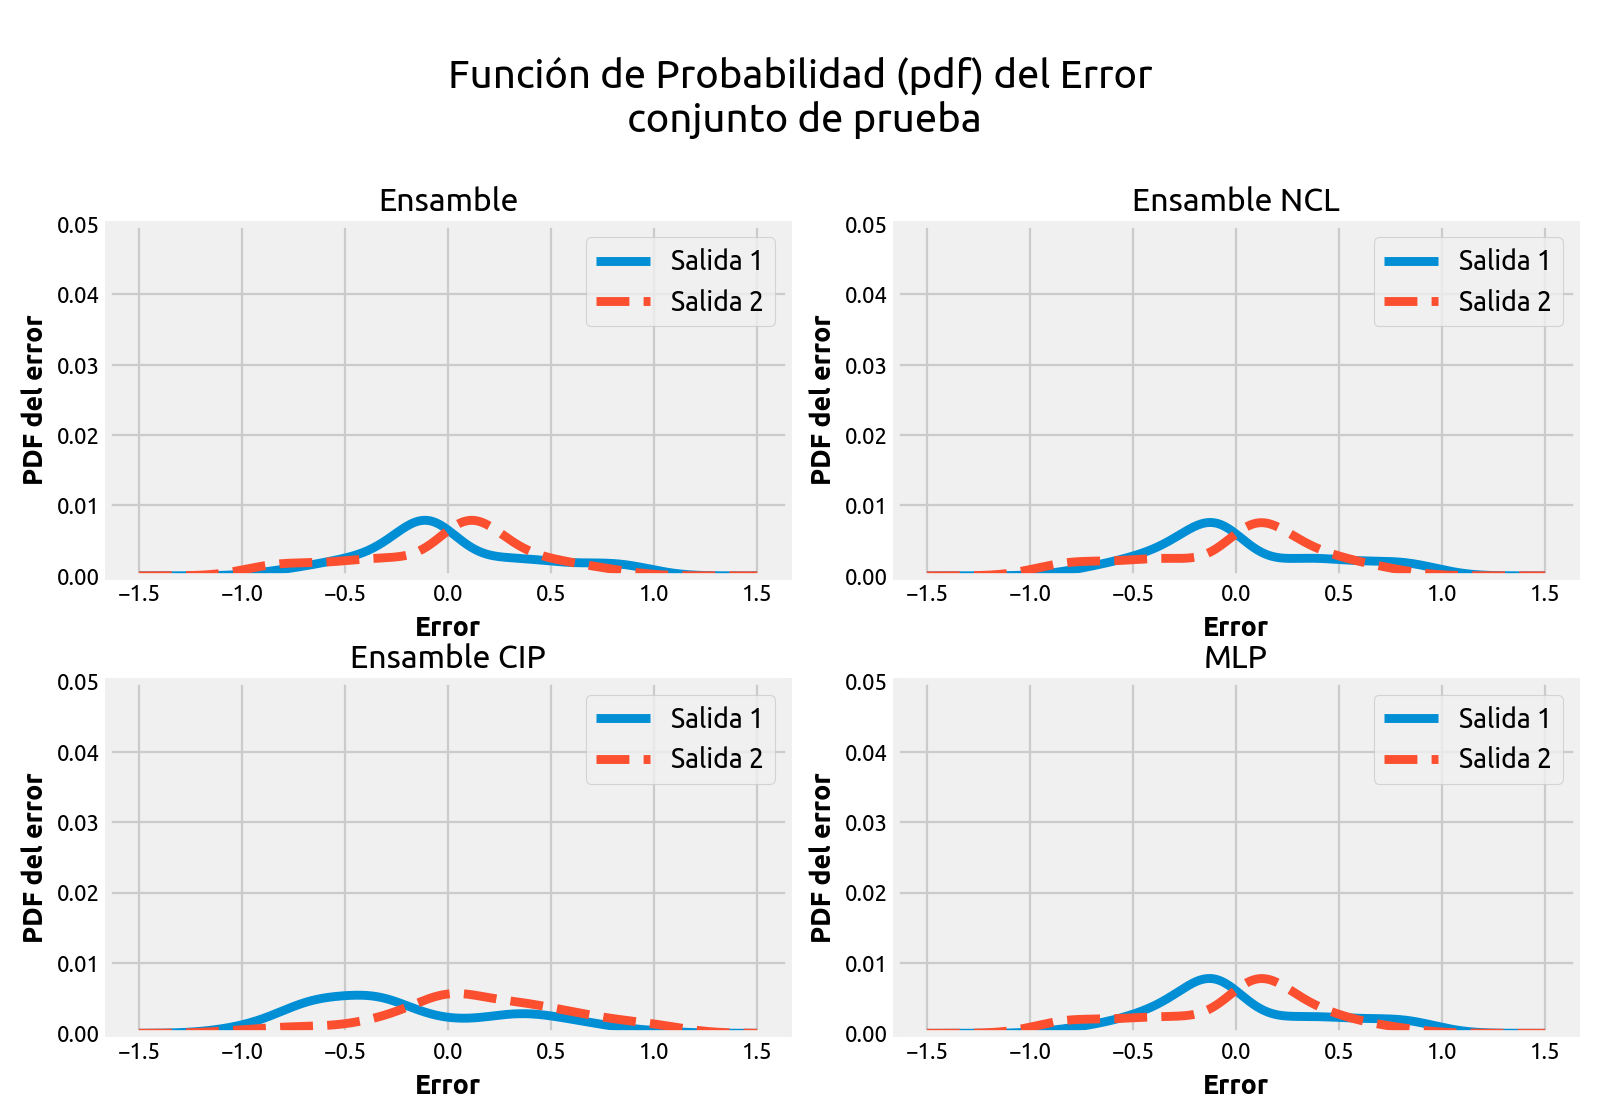

In [9]:
fig = plt.figure(figsize=(10, 7), dpi=80)

ax = fig.add_subplot(2, 2, 1)
plot_pdf_error(ensemble, input_test, target_test, 'Ensamble', ax, fig)

ax = fig.add_subplot(2, 2, 2)
plot_pdf_error(ensembleNCL, input_test, target_test, 'Ensamble NCL', ax, fig)

ax = fig.add_subplot(2, 2, 3)
plot_pdf_error(ensembleCIP, input_test, target_test, 'Ensamble CIP', ax, fig)

ax = fig.add_subplot(2, 2, 4)
plot_pdf_error(mlp, input_test, target_test, 'MLP', ax, fig)

st = fig.suptitle("Función de Probabilidad (pdf) del Error\n conjunto de prueba", fontsize=18)

st.set_y(0.95)
fig.subplots_adjust(top=0.8)

plt.show()

In [10]:
score_test_ensemble = ensemble.score(input_test, target_test)
score_train_ensemble = ensemble.score(input_train, target_train)

score_test_ensembleNCL = ensembleNCL.score(input_test, target_test)
score_train_ensembleNCL = ensembleNCL.score(input_train, target_train)

score_test_ensembleCIP = ensembleCIP.score(input_test, target_test)
score_train_ensembleCIP = ensembleCIP.score(input_train, target_train)

score_test_mlp = mlp.score(input_test, target_test)
score_train_mlp = mlp.score(input_train, target_train)

print('Score Precisión')
print('Ensamble MSE: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble CIP: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP: %f / %f' % (score_train_mlp, score_test_mlp))

Score Precisión
Ensamble MSE: 0.794286 / 0.756667
Ensamble NCL: 0.800000 / 0.743333
Ensamble CIP: 0.662857 / 0.563333
MLP: 0.807143 / 0.770000


<IPython.core.display.Javascript object>


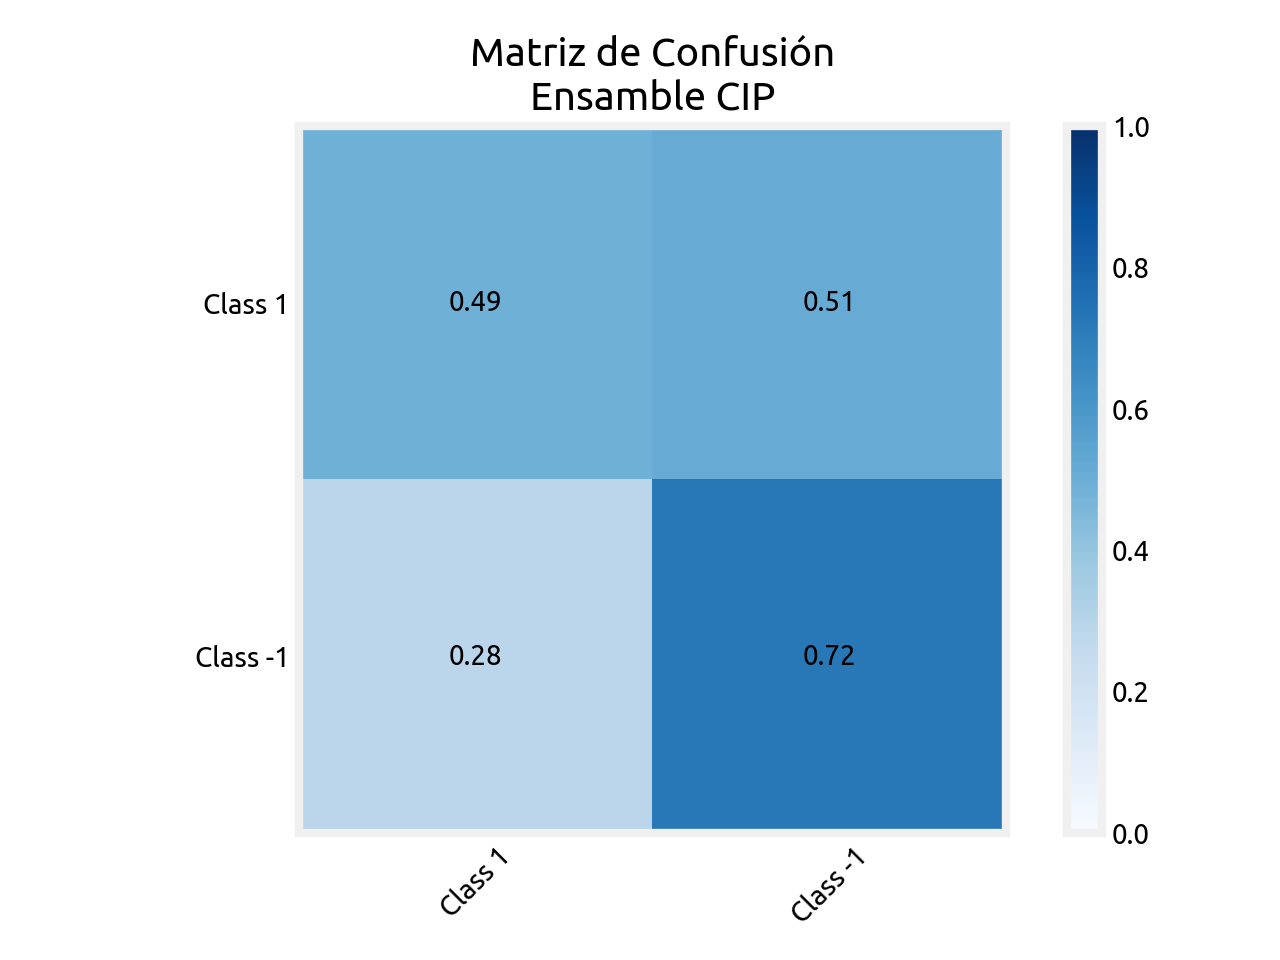

In [11]:
metrics_ensembleCIP.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensembleCIP.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble CIP')
plt.show()

<IPython.core.display.Javascript object>


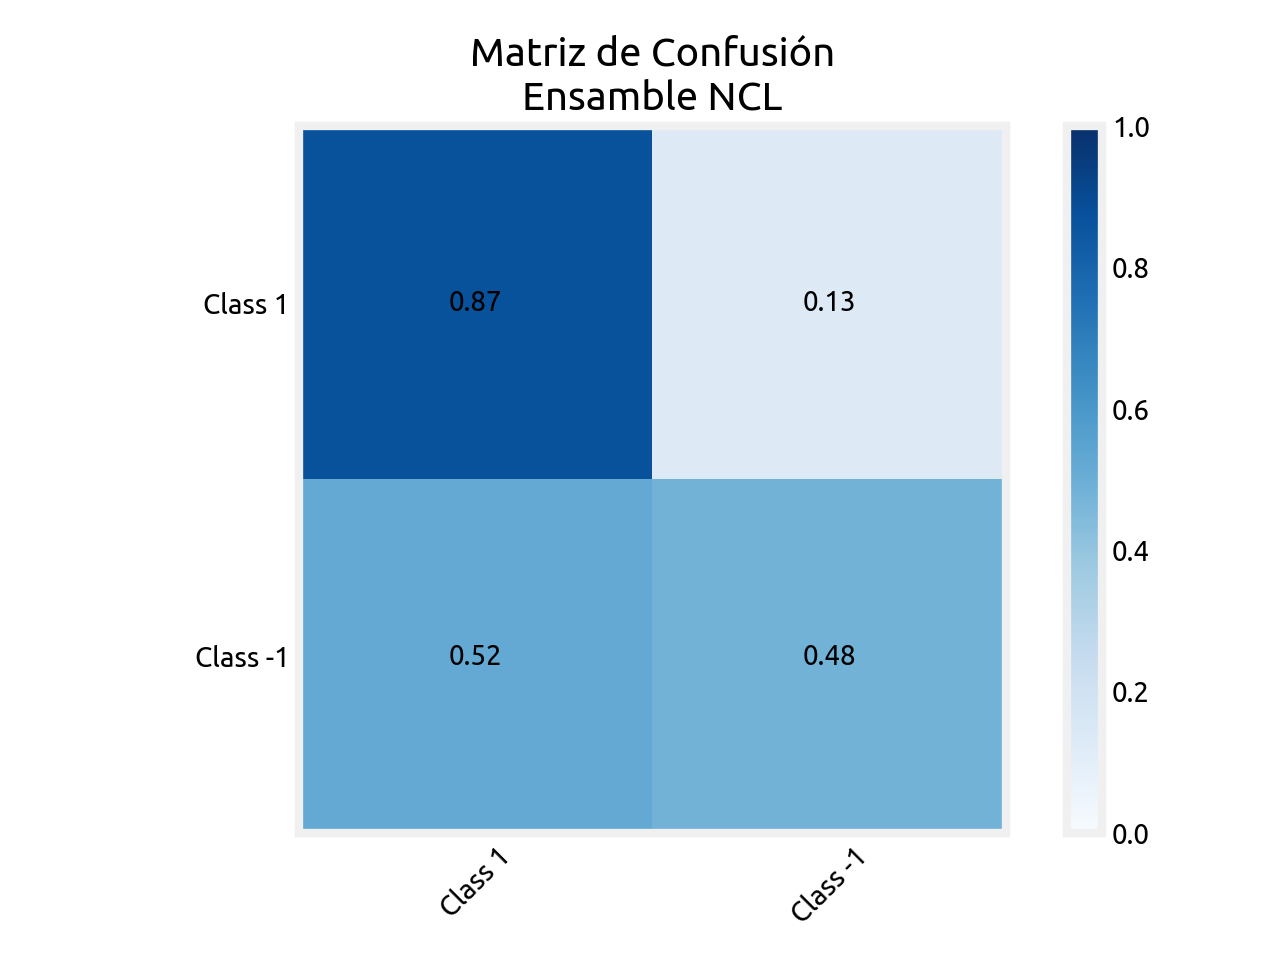

In [12]:
metrics_ensembleNCL.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensembleNCL.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble NCL')
plt.show()

<IPython.core.display.Javascript object>


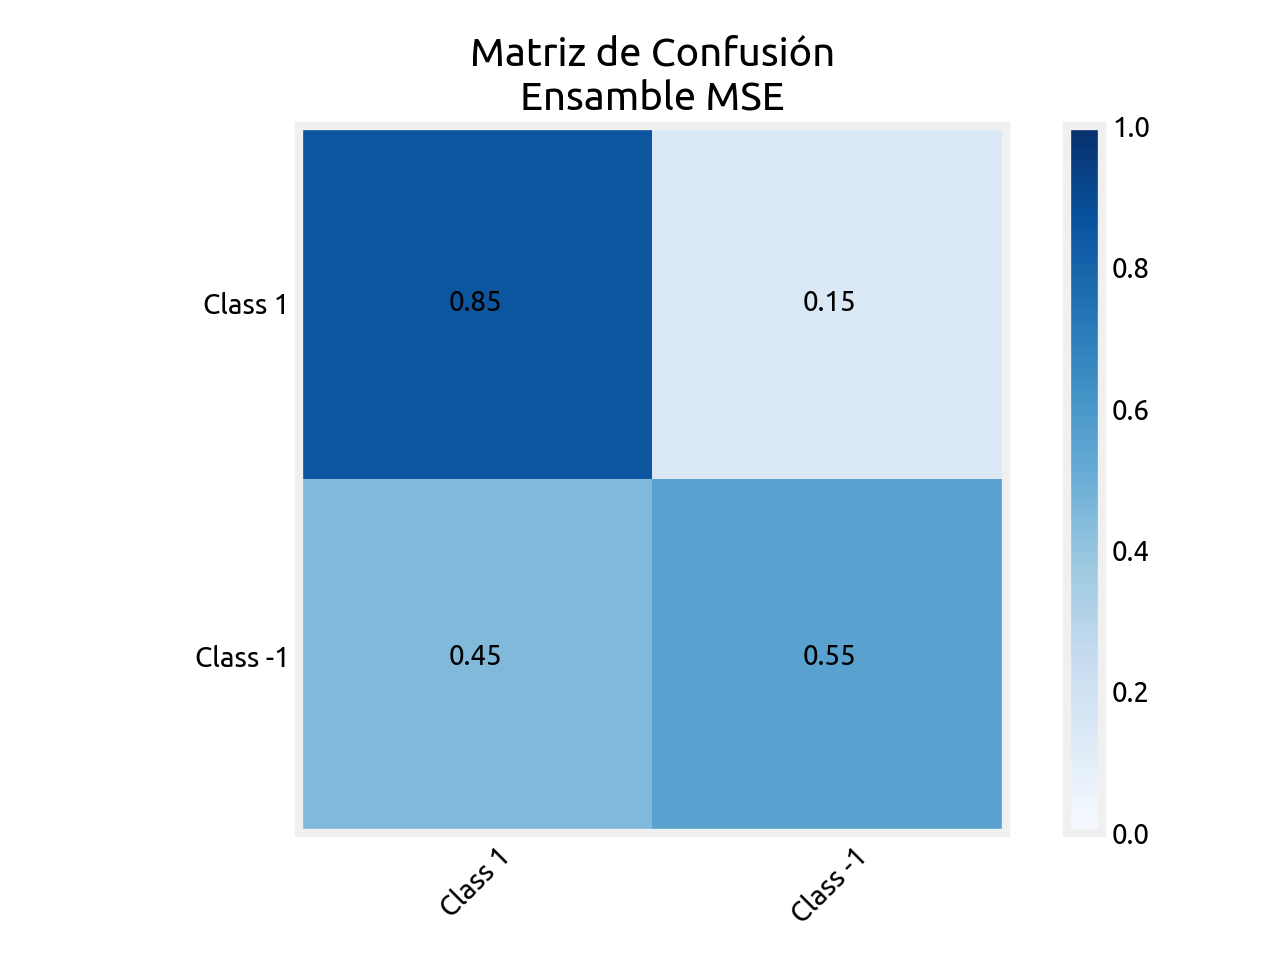

In [13]:
metrics_ensemble.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensemble.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble MSE')
plt.show()

<IPython.core.display.Javascript object>


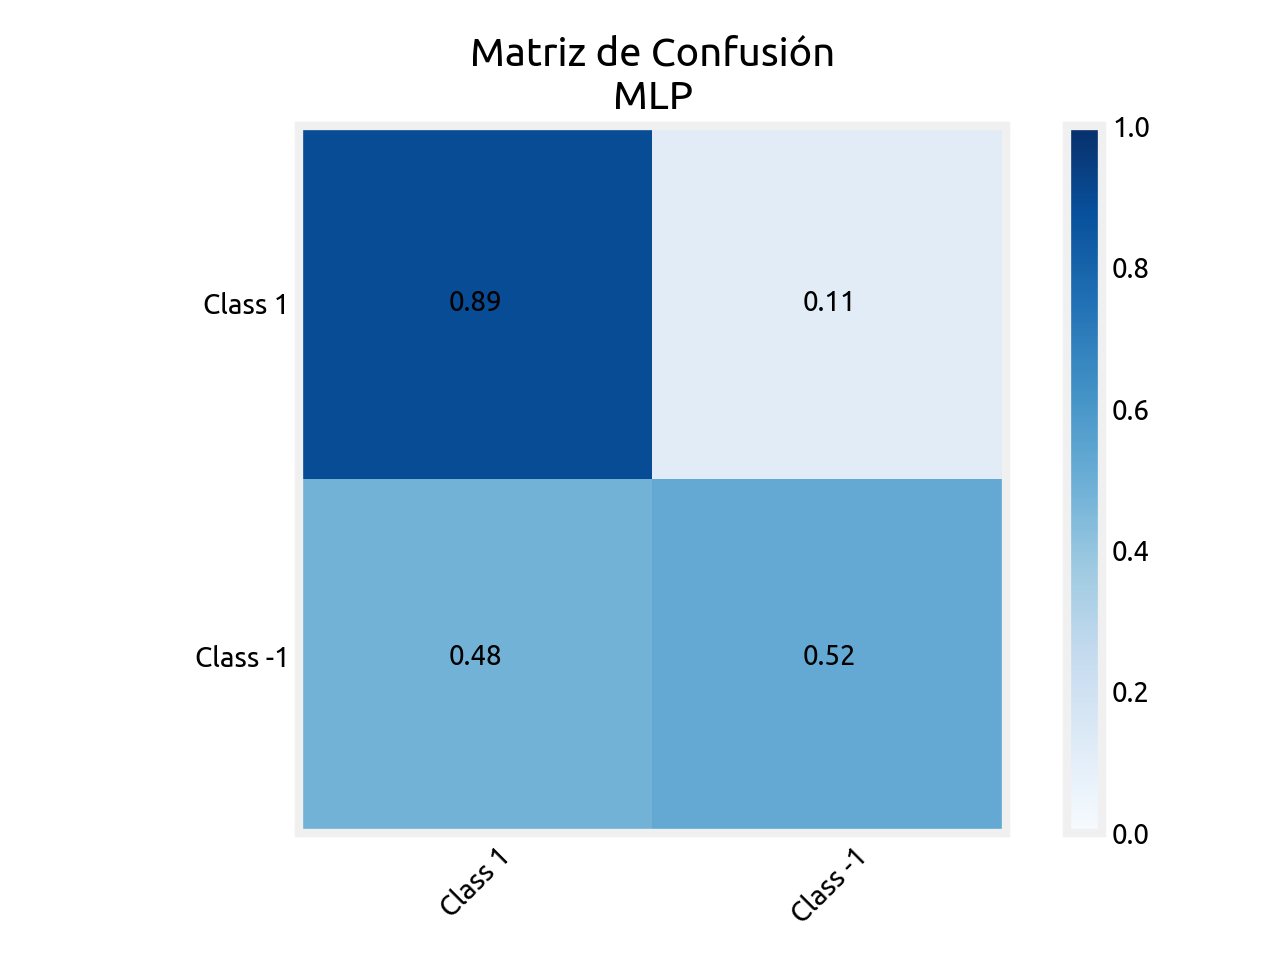

In [14]:
metrics_mlp.append_prediction(input_test, target_test, append_last_pred=True)
metrics_mlp.plot_confusion_matrix(title='Matriz de Confusión\nMLP')
plt.show()

In [15]:
def get_ensemble_cip_cs(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL CS',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    classification=True,
                                    is_cip_full=False,
                                    classes_labels=classes_labels,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lsp=1.5, lsm=0.5,
                                    lr=0.1,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.1}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

def get_ensemble_cip_ed(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL ED',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    classification=True,
                                    is_cip_full=False,
                                    classes_labels=classes_labels,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lsp=1.5, lsm=0.1,
                                    lr=0.1,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.5}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

In [16]:
parameters = [n for n in np.linspace(-1, 1, 21)]

score_cs = []
diversity_cs = []
for p in parameters:
    model_cs = get_ensemble_cip_cs(p, s)
    metric = model_cs.fit(input_train, target_train, **args_train_cip)
    score_cs.append(model_cs.score(input_test, target_test))
    metric.append_prediction(input_test, target_test, append_last_pred=True)
    diversity_cs.append(
        (metric.get_diversity(metric=kohavi_wolpert_variance),
         metric.get_diversity(metric=generalized_diversity),
         metric.get_diversity(metric=coincident_failure),
         metric.get_diversity(metric=entropy_sk),
         metric.get_diversity(metric=difficulty),
        ))

Comienza la compilación Ensamble CIPL CS  - elapsed: 9.49 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 20.55[s] - left: 0.00[s] | score: 0.6382 / 0.68759
Comienza la compilación Ensamble CIPL CS  - elapsed: 8.83 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 20.19[s] - left: 0.00[s] | score: 0.6414 / 0.67192
Comienza la compilación Ensamble CIPL CS  - elapsed: 9.11 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 20.73[s] - left: 0.00[s] | score: 0.6349 / 0.60944
Comienza la compilación Ensamble CIPL CS  - elapsed: 9.56 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 20.86[s] - left: 0.00[s] | score: 0.6595 / 0.62506
Comienza la compilación Ensamble CIPL CS  - elapsed: 9.91 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 22.14[s] - left: 0.00[s] | score: 0.6678 / 0.56255
Comienza la compilación Ensamble CIPL CS  - elapsed: 10.90 [s]
En

In [17]:
score_ed = []
diversity_ed = []
for p in parameters:
    model_ed = get_ensemble_cip_ed(p, s)
    metric = model_ed.fit(input_train, target_train, **args_train_cip)
    score_ed.append(model_ed.score(input_test, target_test))
    metric.append_prediction(input_test, target_test, append_last_pred=True)
    diversity_ed.append(
        (metric.get_diversity(metric=kohavi_wolpert_variance),
         metric.get_diversity(metric=generalized_diversity),
         metric.get_diversity(metric=coincident_failure),
         metric.get_diversity(metric=entropy_sk),
         metric.get_diversity(metric=difficulty),
        ))

Comienza la compilación Ensamble CIPL ED  - elapsed: 9.90 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 23.03[s] - left: 0.00[s] | score: 0.6990 / 0.71884
Comienza la compilación Ensamble CIPL ED  - elapsed: 9.96 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 23.31[s] - left: 0.00[s] | score: 0.6974 / 0.71881
Comienza la compilación Ensamble CIPL ED  - elapsed: 8.91 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 24.81[s] - left: 0.00[s] | score: 0.7039 / 0.68755
Comienza la compilación Ensamble CIPL ED  - elapsed: 8.92 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 22.29[s] - left: 0.00[s] | score: 0.7023 / 0.68751
Comienza la compilación Ensamble CIPL ED  - elapsed: 9.54 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 22.34[s] - left: 0.00[s] | score: 0.6908 / 0.68752
Comienza la compilación Ensamble CIPL ED  - elapsed: 8.97 [s]
Ens

<IPython.core.display.Javascript object>


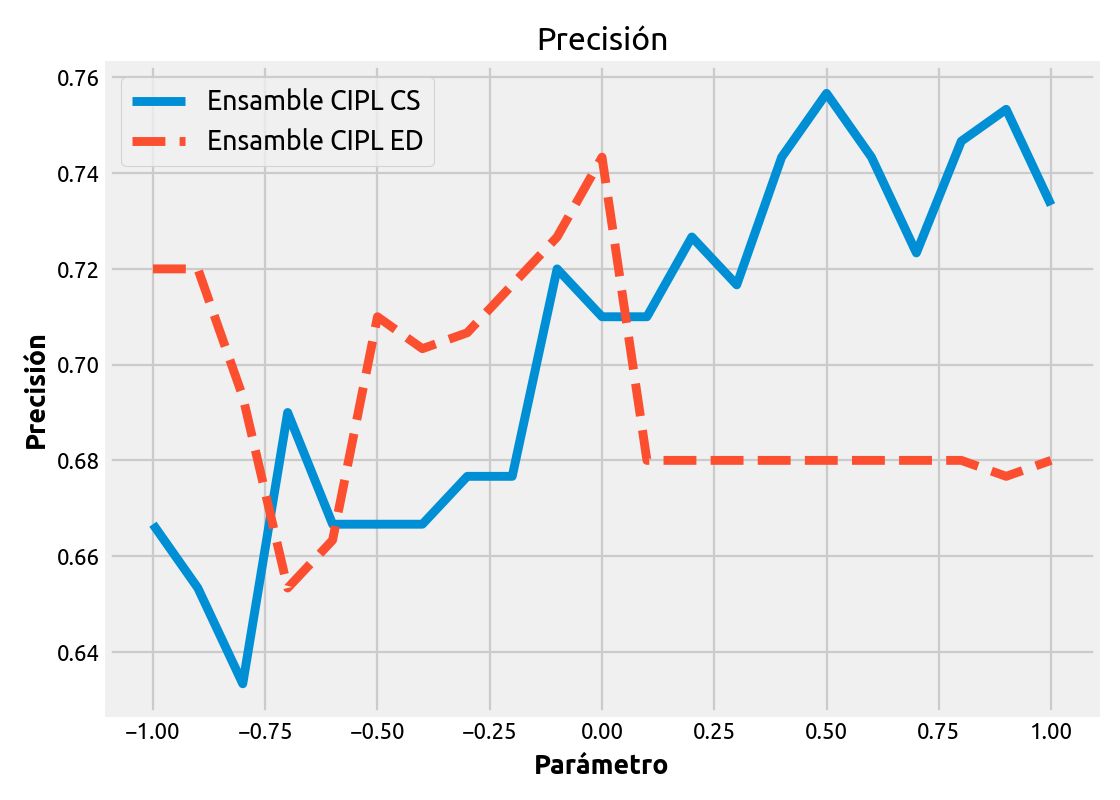

<IPython.core.display.Javascript object>


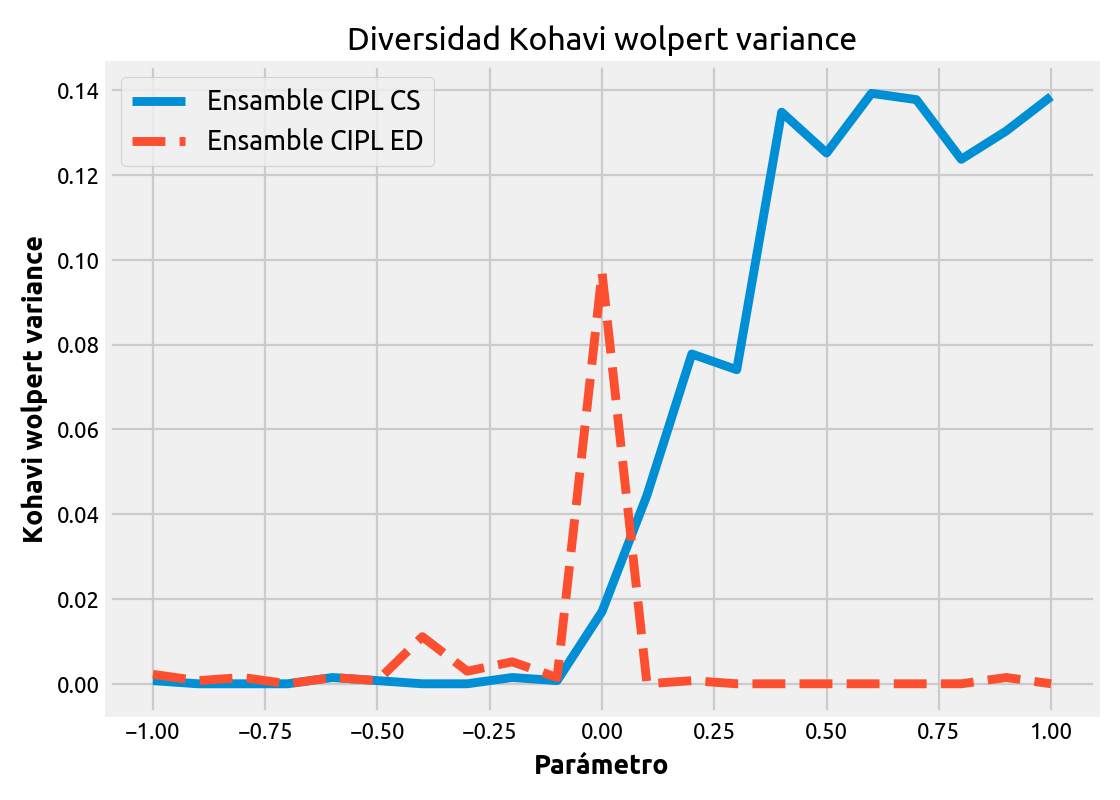

<IPython.core.display.Javascript object>


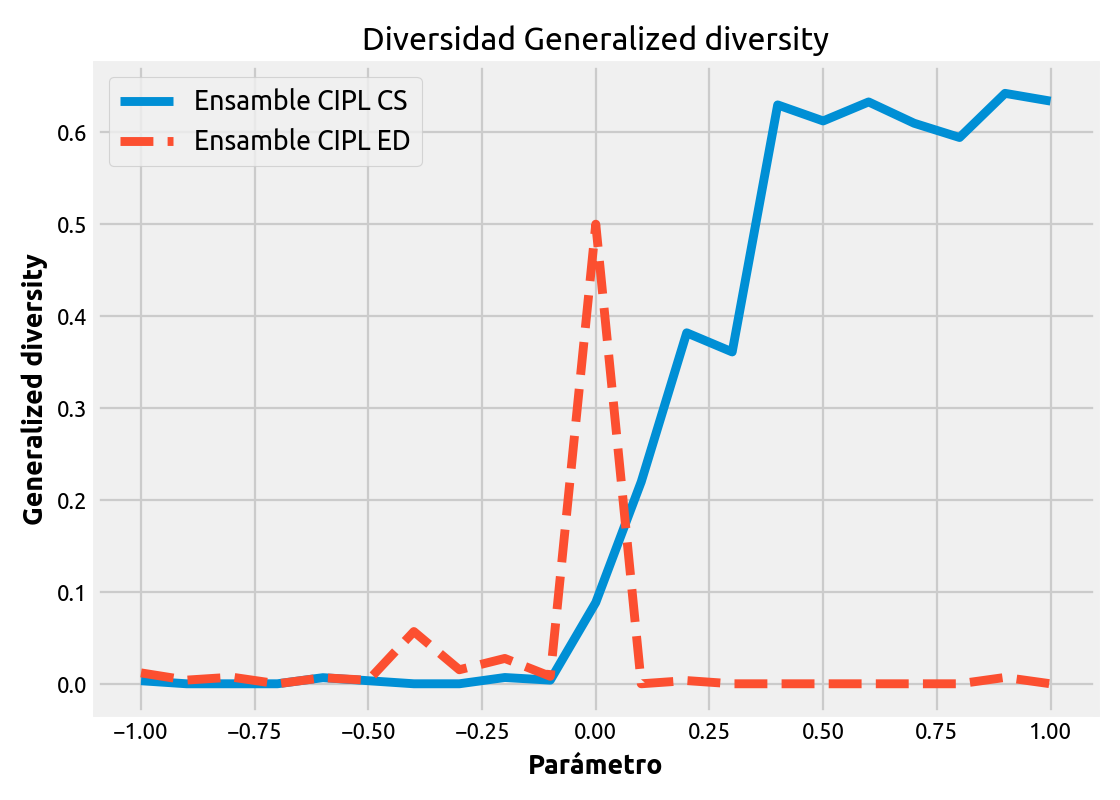

<IPython.core.display.Javascript object>


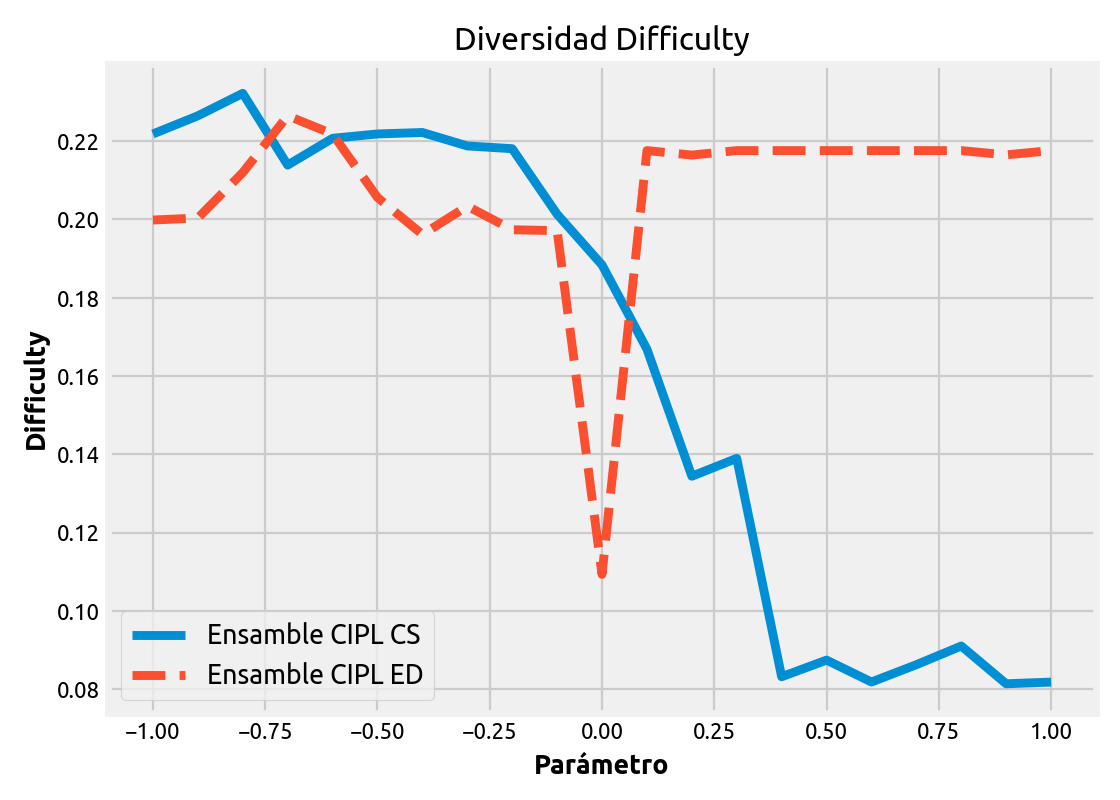

In [18]:
score_cs = np.array(score_cs)
diversity_cs = np.array(diversity_cs)
score_ed = np.array(score_ed)
diversity_ed = np.array(diversity_ed)

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, score_cs, linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, score_ed, linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Precisión')
plt.xlabel('Parámetro')
plt.ylabel('Precisión')
plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, diversity_cs[:,0, 0], linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, diversity_ed[:,0, 0], linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Diversidad Kohavi wolpert variance')
plt.xlabel('Parámetro')
plt.ylabel('Kohavi wolpert variance')
plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, diversity_cs[:,1, 0], linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, diversity_ed[:,1, 0], linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Diversidad Generalized diversity')
plt.xlabel('Parámetro')
plt.ylabel('Generalized diversity')
plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, diversity_cs[:,4, 0], linestyle='-', label='Ensamble CIPL CS')
plt.plot(parameters, diversity_ed[:,4, 0], linestyle='--', label='Ensamble CIPL ED')
plt.legend()
plt.title('Diversidad Difficulty')
plt.xlabel('Parámetro')
plt.ylabel('Difficulty')
plt.tight_layout()

plt.show()

In [19]:
model_cs = get_ensemble_cip_cs(0.5, s)
model_cs.fit(input_train, target_train, **args_train_cip)

Comienza la compilación Ensamble CIPL CS  - elapsed: 8.76 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 20.43[s] - left: 0.00[s] | score: 0.7747 / 0.65620


In [20]:
model_ed = get_ensemble_cip_ed(0.5, s)
model_ed.fit(input_train, target_train, **args_train_cip)

Comienza la compilación Ensamble CIPL ED  - elapsed: 9.48 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 20.72[s] - left: 0.00[s] | score: 0.7105 / 0.7031


In [21]:
noise = [n for n in np.linspace(0.01, 1, 10)]
score_snr_cs = []
score_snr_ed = []
score_snr_ncl = []
score_snr_en = []
score_snr_mlp = []
SNR = []
N = input_test.shape[0]
F = input_test.shape[1]
mu = 0.2

for n in noise:
    ne = np.random.randn(N, F) * n + mu
    z = input_test + ne
    score_snr_cs.append(model_cs.score(z, target_test))
    score_snr_ed.append(model_ed.score(z, target_test))
    score_snr_ncl.append(ensembleNCL.score(z, target_test))
    score_snr_en.append(ensemble.score(z, target_test))
    score_snr_mlp.append(mlp.score(z, target_test))
    SNR.append(np.var(input_test) / np.var(ne))

<IPython.core.display.Javascript object>


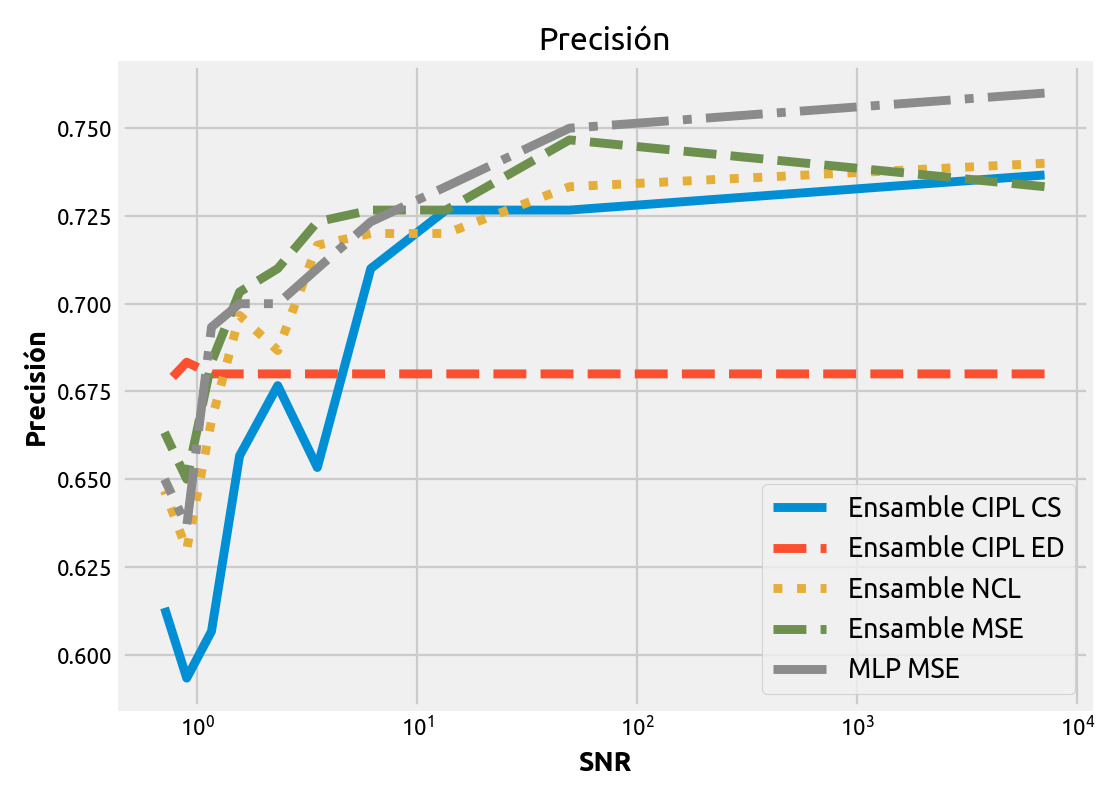

In [22]:
f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(SNR, score_snr_cs, linestyle='-', label='Ensamble CIPL CS')
plt.plot(SNR, score_snr_ed, linestyle='--', label='Ensamble CIPL ED')
plt.plot(SNR, score_snr_ncl, linestyle=':', label='Ensamble NCL')
plt.plot(SNR, score_snr_en, linestyle='--', label='Ensamble MSE')
plt.plot(SNR, score_snr_mlp, linestyle='-.', label='MLP MSE')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Precisión')
plt.xlabel('SNR')
plt.ylabel('Precisión')
plt.tight_layout()

plt.show()